# Correlation of meta variables

When looking at a simple linear regression

$
    y = \beta x + \alpha
$

it can be shown that the meta-variables of this regression, response variance ($\sigma_y$), predictor variance ($\sigma_x$), effect size ($\beta$) and residual variance ($\sigma_\epsilon$) must fulfill the following equation.

$
    \sigma_\epsilon^2 = \sigma_y^2 - \beta^2\sigma_x^2
$

This is visualized in this notebook.

## Imports

In [1]:
import matplotlib

matplotlib.rc('font', size=10, family='serif')
matplotlib.rc('text', usetex=True)

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.transforms as mtransforms


colors = ['#5BC0EB', '#9BC53D', '#E55934', '#FA7921']


## Helper function definitions

In [2]:
def ols(x, y): 
    """Ordinary least squares regression."""
    beta = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x))**2)
    alpha = np.mean(y) - beta * np.mean(x)
    sigma = np.sqrt(np.sum((y - alpha - beta * x)**2)/(len(x)))
    aic = -2 * (-len(x) / 2 * np.log(2 * np.pi * sigma**2) - len(x) / 2) + 2 * 2

    return alpha, beta, sigma, aic

def sigma_eps(beta, sigma_x, sigma_y):
    """Implementation of the correlation between meta-variables"""
    return np.sqrt(sigma_y**2 - beta**2 * sigma_x**2)

def run_simulations(y, n_repeats = 1000, x_var = 1, x_random=0, max_error = 4):
    """Simulate many different predictors for a single response.

    This function will generate many different random predictors, either dependent (x_random != 0) on the 
    response or independent (x_random = 0) of it. Then, a linear model is fit between the predictor and the
    response. All relevant variables are recorded, yielding many examples for a model selection scenario.
    
    """
    betas = np.zeros(n_repeats)
    scales = np.zeros(n_repeats)
    sample_size = y.shape[0]
    
    for i, add_error in enumerate(np.linspace(0.0001, max_error, n_repeats)):
        x_err = np.random.normal(0, add_error, sample_size)
        x = x_random * y + x_err
        x = (x - np.mean(x)) / np.std(x) * x_var

        alpha, beta, sigma, aic = ols(x, y)
        betas[i] = beta
        scales[i] = sigma

    return betas, scales

def plot_xy(x, y, ax, colors):
    """Plot the data and the regression line."""
    alpha, beta, sigma, aic = ols(x, y)
    ax.vlines(x, y, alpha + beta * x, colors=colors)
    for x_val, y_val, c in zip(x, y, colors):
        ax.plot(x_val, y_val, 'o', color=c)

    
    x_plot = np.array([-1, 2])
    ax.plot(x_plot, alpha + beta * x_plot, color='black')

    ax.text(0.05, 0.95,
            r'$\beta = ' + f'{beta:.2}$\n$' + r'\sigma_\epsilon' + f' = {sigma:.2}$\n$\sigma_x = {np.std(x):.2}$',
            transform=ax.transAxes,
            verticalalignment='top')  
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0.05, 0.9)

Generate random predictor variables for different y-variances. These are then used as data for the first plot. This is not used in the final publication.

In [5]:
n_repeats = 1000

sample_size = 100
x_vars = [1, 0.9, 1.7]
y_vars = [1, 1.5, 2]
betas = np.zeros((len(x_vars), n_repeats * 3))
scales = np.zeros((len(x_vars), n_repeats * 3))

for i in range(len(y_vars)): 
    y = np.random.normal(0, 2, sample_size)
    y = (y - np.mean(y)) / np.std(y) * y_vars[i]

    betas1, scales1 = run_simulations(y, n_repeats=n_repeats, x_var=x_vars[i], x_random=0)
    betas2, scales2 = run_simulations(y, n_repeats=n_repeats, x_var=x_vars[i], x_random=1)
    betas3, scales3 = run_simulations(y, n_repeats=n_repeats, x_var=x_vars[i], x_random=-1)

    betas[i] = np.append(np.append(betas1, betas2), betas3)
    scales[i] = np.append(np.append(scales1, scales2), scales3)

This figure shows the perfect correlation between effect size ($\beta$) and residual variance ($\sigma_\epsilon$). This is not used in the final publication.

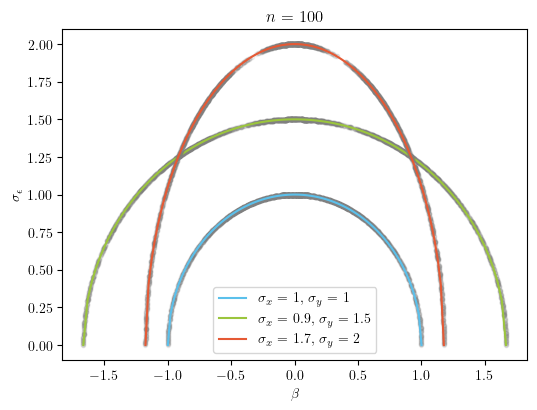

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4.3)

for i in range(len(x_vars)):
    x = np.linspace(np.min(betas[i]), np.max(betas[i]), 100)
    y = sigma_eps(x, x_vars[i], y_vars[i])
    ax.plot(betas[i], scales[i], '.', alpha=0.1, color='grey')
    ax.plot(x, y, color=colors[i], label=f'$\sigma_x$ = {x_vars[i]}, $\sigma_y$ = {y_vars[i]}')

ax.legend()
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\sigma_\epsilon$')
ax.set_title(f'$n$ = {sample_size}')

fig.savefig('plots/sigma_eps_beta_sigma_x.pdf')

## Code for Figure 1 in the manuscript

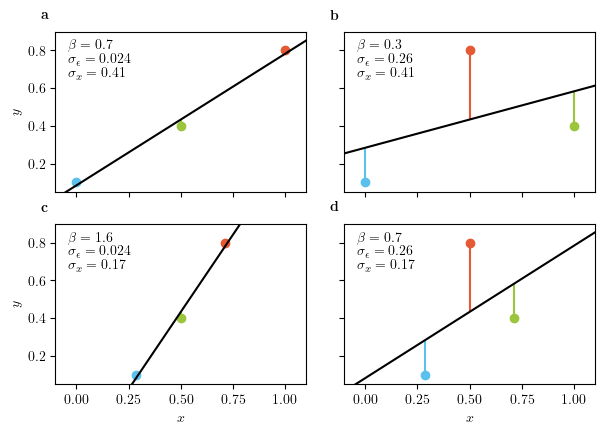

In [9]:
fig, axes = plt.subplot_mosaic([['a', 'b'], ['c', 'd']], sharex=True, sharey=True, 
                               gridspec_kw=dict(
                                    hspace=0.2,
                                    wspace=0.15,
                                    top=0.92,bottom=0.1,left=0.09,right=0.99,
                               ))

fig.set_size_inches(6, 4.3)

for label, ax1 in axes.items():
    # label physical distance to the left and up:
    if label == 'legend':
        continue
    trans = mtransforms.ScaledTranslation(-10/72, 7/72, fig.dpi_scale_trans)
    ax1.text(0, 1.0, r'\textbf{' + label + '}', transform=ax1.transAxes + trans,
            weight='bold', va='bottom')

y = np.array([0.1, 0.4, 0.8])

x = np.array([0, 0.5, 1])
plot_xy(x, y, axes['a'], colors[:3])

x = np.array([0, 1, 0.5])
plot_xy(x, y, axes['b'], colors[:3])

x = np.array([0.287, 0.5, 0.713])
plot_xy(x, y, axes['c'], colors[:3])

x = np.array([0.287, 0.713, 0.5])
plot_xy(x, y, axes['d'], colors[:3])

ax = axes['a']
ax.set_ylabel('$y$')

ax = axes['b']
plt.setp(ax.get_yticklabels(), visible=False)

ax = axes['c']
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax = axes['d']
ax.set_xlabel('$x$')

#axes[0, 0].set_ylabel(r'$y$')
#axes[1, 0].set_ylabel(r'$y$')
#axes[1, 0].set_xlabel(r'$x$')
#axes[1, 1].set_xlabel(r'$x$')

fig.savefig('plots/ols_example.pdf')